In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Model Definition

In [6]:
# CONSTANTS

THETA   = 1/2
KAPPA   = 1/2
OMEGA_A = 0.1
OMEGA_U = 0.1
GAMMA_U = 0.9
BETA_U  = 0.1 
BETA_A  = 0.1 
ALPHA_U = 1
SIGMA_D = 1
LAMBDA  = 1

In [ ]:
# DEFINE THE MATRICES

A = np.array([
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, THETA, THETA - KAPPA],
        [0, 0, 0, 1 - OMEGA_A, 0],
        [0, 0, 0, 0, 1 - OMEGA_U]])
B = np.array([1, GAMMA_U, (THETA - KAPPA) * GAMMA_U, 0, OMEGA_U * BETA_U])

Sigma_x = np.array([
    [0, 0, 0, 0, 0], 
    [0, SIGMA_D**2, THETA*SIGMA_D**2, 0, 0],
    [0, THETA*SIGMA_D**2, THETA**2*SIGMA_D**2, 0, 0],
    [0, 0, 0, BETA_A**2, 0],
    [0, 0, 0, 0, 0]])

Q = np.array([
    [LAMBDA*SIGMA_D**2, 0, 0, -1/2, -1/2], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0],
    [-1/2, 0, 0, 0, 0]])


S = np.array([
    [LAMBDA*THETA*SIGMA_D**2 - GAMMA_U/2, 0, 0, -THETA/2, -(THETA - KAPPA)/2]])


R = np.array([[LAMBDA*THETA**2*SIGMA_D**2 - (THETA - KAPPA)*GAMMA_U]])

C = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0]])

L = np.block([[Q, S.T], [S, R]])

# Question 1

------ LQG Gains ------


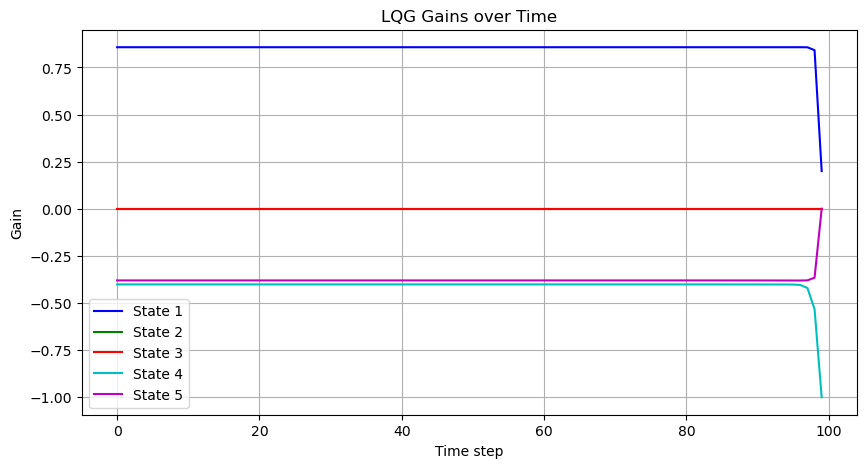

K =  [ 0.85724945  0.          0.         -0.40135333 -0.38022947]
Eigenvalues of A - B @ K:  [0.         0.14705784 0.89949501 0.         0.9       ]
Eigenvalues of A:  [1.  0.  0.  0.9 0.9]
Is the closed loop system asymptotically stable?  True
Is the open loop system marginally stable?  True
Is the open loop system asymptotically stable?  False


In [112]:
def computeLQG_gains(Q, R, S, A, B, R0, nsteps):
    
    M_k_plus = R0
    K_matrix = np.zeros((B.shape[1], B.shape[0], nsteps)) 
    
    for k in range(nsteps-1, -1, -1):
        K_k = np.linalg.inv(R + B.T @ M_k_plus @ B) @ (B.T @ M_k_plus @ A + S.T)
        M_k_plus = Q + A.T @ M_k_plus @ A - (A.T @ M_k_plus @ B + S)@ K_k
        K_matrix[:,:,k] = K_k
    
    return K_matrix

def plot_LQG_gains(LQG_gains):
    # Plot LQG gains over time
    colors = ['b', 'g', 'r', 'c', 'm']
    plt.figure(figsize=(10, 5))
    for i in range(LQG_gains.shape[1]):
        plt.plot(LQG_gains[0,i,:], label=f"State {i+1}", color=colors[i]) # Skip the last 5 values to avoid the plot of R_0 
    plt.xlabel("Time step")
    plt.ylabel("Gain")
    plt.title("LQG Gains over Time")
    plt.legend()
    plt.grid()
    plt.show()

R0 = np.zeros((5,5))
LQG_gains = computeLQG_gains(Q, R, S.reshape((-1,1)), A, B.reshape((-1,1)), R0, 100)
print("------ LQG Gains ------")
plot_LQG_gains(LQG_gains)
print("K = ", LQG_gains[0,:,0])

# Compute the eigenvalues of A - B @ K with K the LQG gains (constant over time)
closed_loop_matrix = A - B.reshape((-1,1)) @ LQG_gains[:,:,0] # Warning: A+BK in the statement
eigenvalues = np.linalg.eigvals(closed_loop_matrix)
print("Eigenvalues of A - B @ K: ", eigenvalues)
print("Eigenvalues of A: ", np.linalg.eigvals(A))
# Check stability
print("Is the closed loop system asymptotically stable? ", np.all(np.abs(eigenvalues) < 1))
print("Is the open loop system marginally stable? ", np.all(np.abs(np.linalg.eigvals(A)) <=1 ))
print("Is the open loop system asymptotically stable? ", np.all(np.abs(np.linalg.eigvals(A)) < 1 ))


In [113]:
K_star = LQG_gains[:,:,0]

# Question 2

In [114]:
def simulateWithKalmanFilter(x0, x0est, P0, Sigma_x, A, B, C, nsteps, K):
    """
    Simulate a system with a Kalman filter.

    Parameters
    ----------
    x0 : np.array
        The initial state of the system.
    x0est : np.array
        The initial estimate of the state of the system.
    P0 : np.array
        The initial estimate of the error covariance matrix.
    Sigma_x : np.array
        The covariance matrix of the process noise.
    A : np.array
        The state transition matrix.
    B : np.array
        The control input matrix.
    C : np.array
        The observation matrix.
    nsteps : int
        The number of time steps to simulate.
    K : np.array
        The LQG gain matrix.
    
    Returns
    -------
    x : np.array
        The state of the system at each time step.
    x_est : np.array
        The estimated state of the system at each time step.
    u : np.array
        The control input at each time step.
    y : np.array
        The measurement at each time step.
    """

    x = np.zeros((A.shape[0], nsteps))  # state at each time step
    x_est = np.zeros((A.shape[0], nsteps))  # estimated state at each time step
    u = np.zeros((B.shape[1], nsteps-1))  # control input at each time step
    y = np.zeros((C.shape[0], nsteps-1))  # measurement at each time step

    # Initialize
    x[:, 0] = x0
    x_est[:, 0] = x0est
    Pk = P0

    for k in range(nsteps - 1):
        # Compute control input using LQG gain
        u[:, k] = -K @ x_est[:, k]

        # Process noise
        w_k = np.random.multivariate_normal(np.zeros(Sigma_x.shape[0]), Sigma_x)
        
        # Simulate the true system
        x[:, k+1] = A @ x[:, k] + B @ u[:, k] + w_k
        
        # Simulate measurement
        y[:, k] = C @ x[:, k] 

        # Kalman Filter Prediction
        x_pred = A @ x_est[:, k] + B @ u[:, k]
        P_pred = A @ Pk @ A.T + Sigma_x

        # Kalman Gain
        K_kalman = P_pred @ C.T @ np.linalg.inv(C @ P_pred @ C.T + 1e-9*np.eye(4))

        # Kalman Filter Update
        x_est[:, k+1] = x_pred + K_kalman @ (y[:, k] - C @ x_pred)
        Pk = (np.eye(Pk.shape[0]) - K_kalman @ C) @ P_pred

    return x, x_est, u, y

# Question 3

### 3.1 Observer Error

In [139]:
nsteps = 200
P0 = Sigma_x

x0 = np.array([5, 0, 0, 0, 0])
list_x0est = [
    np.array([5, 0, 0, 0, 5]),
    np.array([5, 0, 0, 0, -10]),
    np.array([5, 0, 0, 0, -50]),
    np.array([5, 0, 0, 0, 100]),
]

list_x = []
list_x_est = []
list_u = []
list_y = []

for x0est in list_x0est:    
    # Simulate the system with the Kalman filter
    x, x_est, u, y = simulateWithKalmanFilter(x0, x0est, P0, Sigma_x, A, B.reshape((-1,1)), C, nsteps, K_star)
    list_x.append(x)
    list_x_est.append(x_est)
    list_u.append(u)
    list_y.append(y)

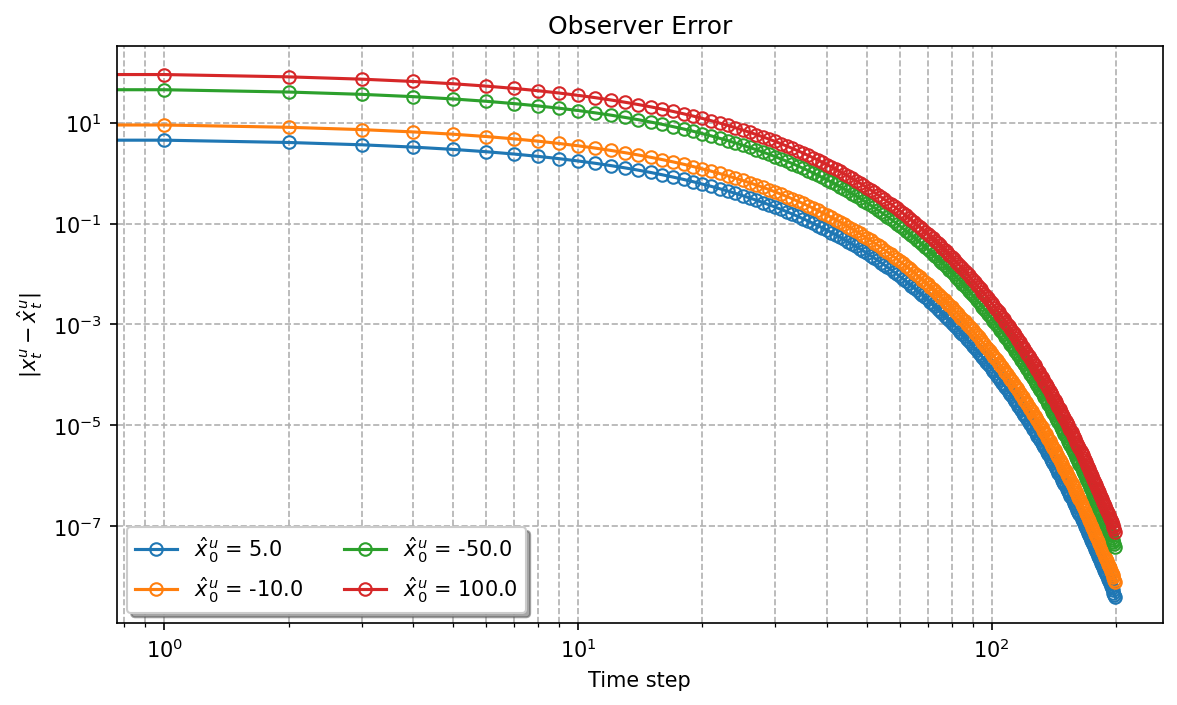

In [138]:
plt.figure(figsize=(9, 5), dpi = 150)

for x, x_est, u, y in zip(list_x, list_x_est, list_u, list_y):
    plt.loglog(np.abs(x[-1, :] - x_est[-1, :]), label=f"$\hat x^u_0$ = {x_est[-1, 0]}", marker = "o", fillstyle = "none")

plt.xlabel("Time step")
plt.ylabel(r"$|x^u_t - \hat x^u_t|$")
plt.title("Observer Error")
plt.grid(True, which="both", axis = "both", ls="--")
plt.legend(ncol = 2, shadow = True)
plt.savefig("figures/observer_error.pdf")
plt.show()

### 3.2 Evolution

We define the function `monte_carlo_simulation` that will perform, with Monte Carlo simulation, the computation of $g_t$

In [119]:
def monte_carlo_simulation(x : np.ndarray, u : np.ndarray, M : int, A : np.ndarray, B : np.ndarray, Sigma_x : np.ndarray):
    """
    Compute the Monte Carlo approximations : 
        * E[g_t | x_t, x_{t-1}, ..., x_0]
        * var[g_t | x_t, x_{t-1}, ..., x_0]
        * E[(x_t u_t) L (x_t u_t)^T | x_t, x_{t-1}, ..., x_0] (with L = [[Q S], [S^T R]])

    and finally compute the LQR cost with the above approximations.
    
    For the N given trajectories (x, u), we compute the conditional expectation and variance of the reward g_t by performing M monte-carlo simulation
    at each time step and for each trajectories.
                    
    Parameters
    ----------
    x : np.ndarray
        State trajectories.
    u : np.ndarray
        Control trajectories.
    M : int
        # of particles for the conditional expectation.
    A : np.ndarray
        System matrix.
    B : np.ndarray
        Control matrix.
    Sigma_x : np.ndarray
        Covariance matrix of the state noise.

    Returns
    -------

    x_monte_carlo : np.ndarray
        State trajectory with the M additional Monte-Carlo simulation.
    
    E_g : np.ndarray
        E[g_t | x_t, x_{t-1}, ..., x_0]    
    V_g : np.ndarray
        var[g_t | x_t, x_{t-1}, ..., x_0]

    LQR : np.ndarray    
        LQR cost 
    
    """

    N_traj, state_dim, nStep = x.shape
    x_monte_carlo = np.zeros((N_traj, M, nStep, state_dim)) 
    g_monte_carlo = np.zeros((N_traj, M, nStep-1,))

    x_monte_carlo[..., 0, :] = x[:, np.newaxis, :, 0]

    for t in range(nStep-1):
        
        w_k = np.random.multivariate_normal(np.zeros(state_dim), Sigma_x, M) # (M, state_dim)
        delta_x =  np.einsum("kl, nl -> nk", A,  x[..., t]) + B  * u[..., t] # (N_traj, state_dim)
        
        x_monte_carlo[..., t+1, :] =  delta_x[:, np.newaxis, :] + w_k
        g_monte_carlo[..., t] = x_monte_carlo[..., t, 0]*x_monte_carlo[..., t+1, 1] + u[...,t]*x_monte_carlo[..., t+1, 2]

    E_g = np.mean(g_monte_carlo, axis=1)
    V_g = np.var(g_monte_carlo, axis=1)

    u_expended = np.tile(np.expand_dims(u, axis = 1), (1, M, 1, 1)).swapaxes(2, 3) # (N_traj, M, nStep, 1)
    v = np.concatenate((x_monte_carlo[..., :nStep-1, :], u_expended), axis=-1) # (N_traj, M, nStep, 6)
    
    LQR_t = np.mean(np.einsum("nmtk, nmtk -> nmt", v, np.einsum("kl, nmtl -> nmtk", L, v)), axis=1)
    LQR = np.mean(np.mean(LQR_t, axis=0))

    return x_monte_carlo, E_g, V_g, LQR

We generate $N_{traj}$ trajectories for 4 inital conditions to compute the expectations afterwards

In [120]:
N_traj = 10
nsteps = 200
P0 = Sigma_x

x0 = np.array([5, 0, 0, 0, 0])

list_x0est = [
    np.array([5, 0, 0, 0, 10]),
    np.array([5, 0, 0, 0, -15]),
    np.array([5, 0, 0, 0, 2]),
    np.array([5, 0, 0, 0, 0])
]
list_Eg, list_LQR = [], []


for x0est in list_x0est:

    list_x, list_x_est, list_u, list_y = [], [], [], []

    for _ in range(N_traj):
        x, x_est, u, y = simulateWithKalmanFilter(x0, x0est, P0, Sigma_x, A, B.reshape((-1,1)), C, nsteps, K_star)
        list_x.append(x)
        list_x_est.append(x_est)
        list_u.append(u)
        list_y.append(y)

    arr_x, arr_x_est, arr_u, arr_y = np.array(list_x), np.array(list_x_est), np.array(list_u), np.array(list_y)
    x_monte_carlo, E_g, V_g, LQR = monte_carlo_simulation(arr_x, arr_u, 100, A, B, Sigma_x)

    list_Eg.append(E_g)
    list_LQR.append(LQR)


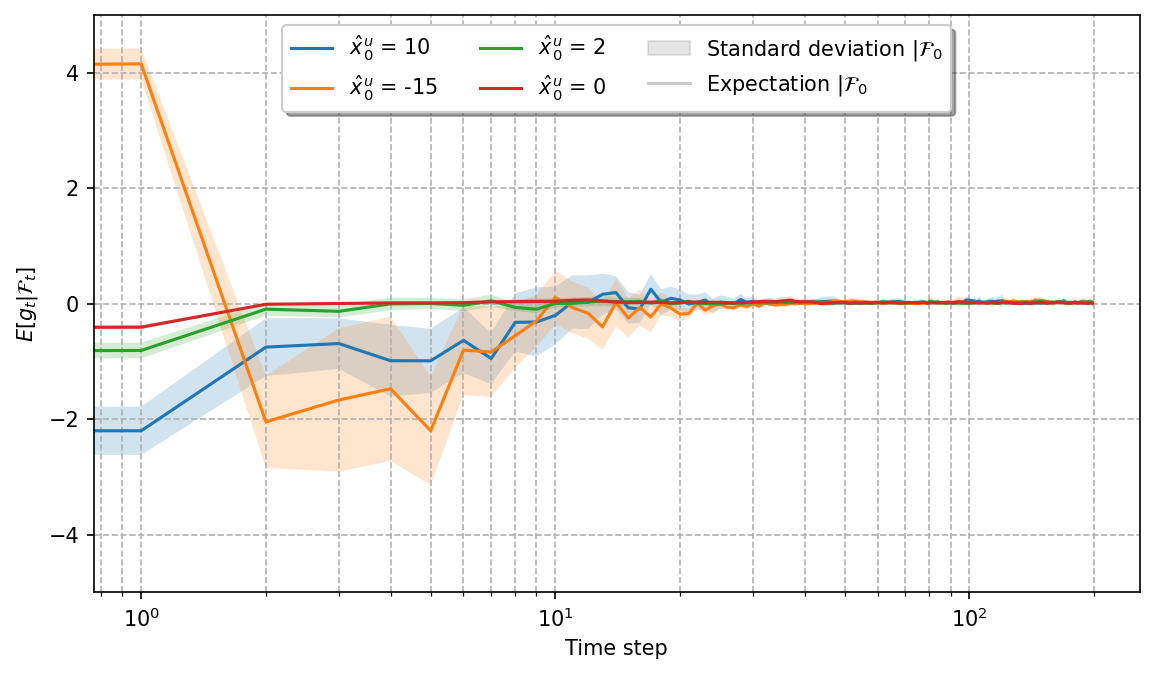

In [121]:

fig = plt.figure(figsize=(9, 5), dpi = 150)

for Eg, x0est in zip(list_Eg, list_x0est):
    mean_g = np.mean(Eg, axis=0)
    var_g = np.var(Eg, axis=0)
    plt.semilogx(mean_g, label=f"$\hat x^u_0$ = {x0est[4]}")
    plt.fill_between(np.arange(nsteps-1), mean_g - np.sqrt(var_g), mean_g + np.sqrt(var_g), alpha=0.2)

plt.fill_between([], [], [], color='gray', alpha=0.2, label=r"Standard deviation $| \mathcal{F}_0$")
plt.plot([], [], label=r"Expectation $|\mathcal{F}_0$", color = "k", alpha = 0.2)
plt.xlabel("Time step")
plt.ylabel(r"$E[g_t|\mathcal{F}_t]$")
plt.ylim(-5, 5)
plt.legend(ncol= 3, loc = "upper center", shadow = True)
plt.grid(True, which="both", axis = "both", ls="--")    
plt.savefig("figures/observer_g_t.pdf")
plt.show()


#### Trajectories

In [122]:
N_traj = 10
nsteps = 200
P0 = Sigma_x

list_x0 = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]

list_x0est = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]

list_u, list_x = [[] for _ in range(N_traj)], [[] for _ in range(N_traj)]


for x0, x0est in zip(list_x0, list_x0est):
    for i in range(N_traj):
        x, x_est, u, y = simulateWithKalmanFilter(x0, x0est, P0, Sigma_x, A, B.reshape((-1,1)), C, nsteps, K_star)

        list_u[i].append(u)
        list_x[i].append(x)


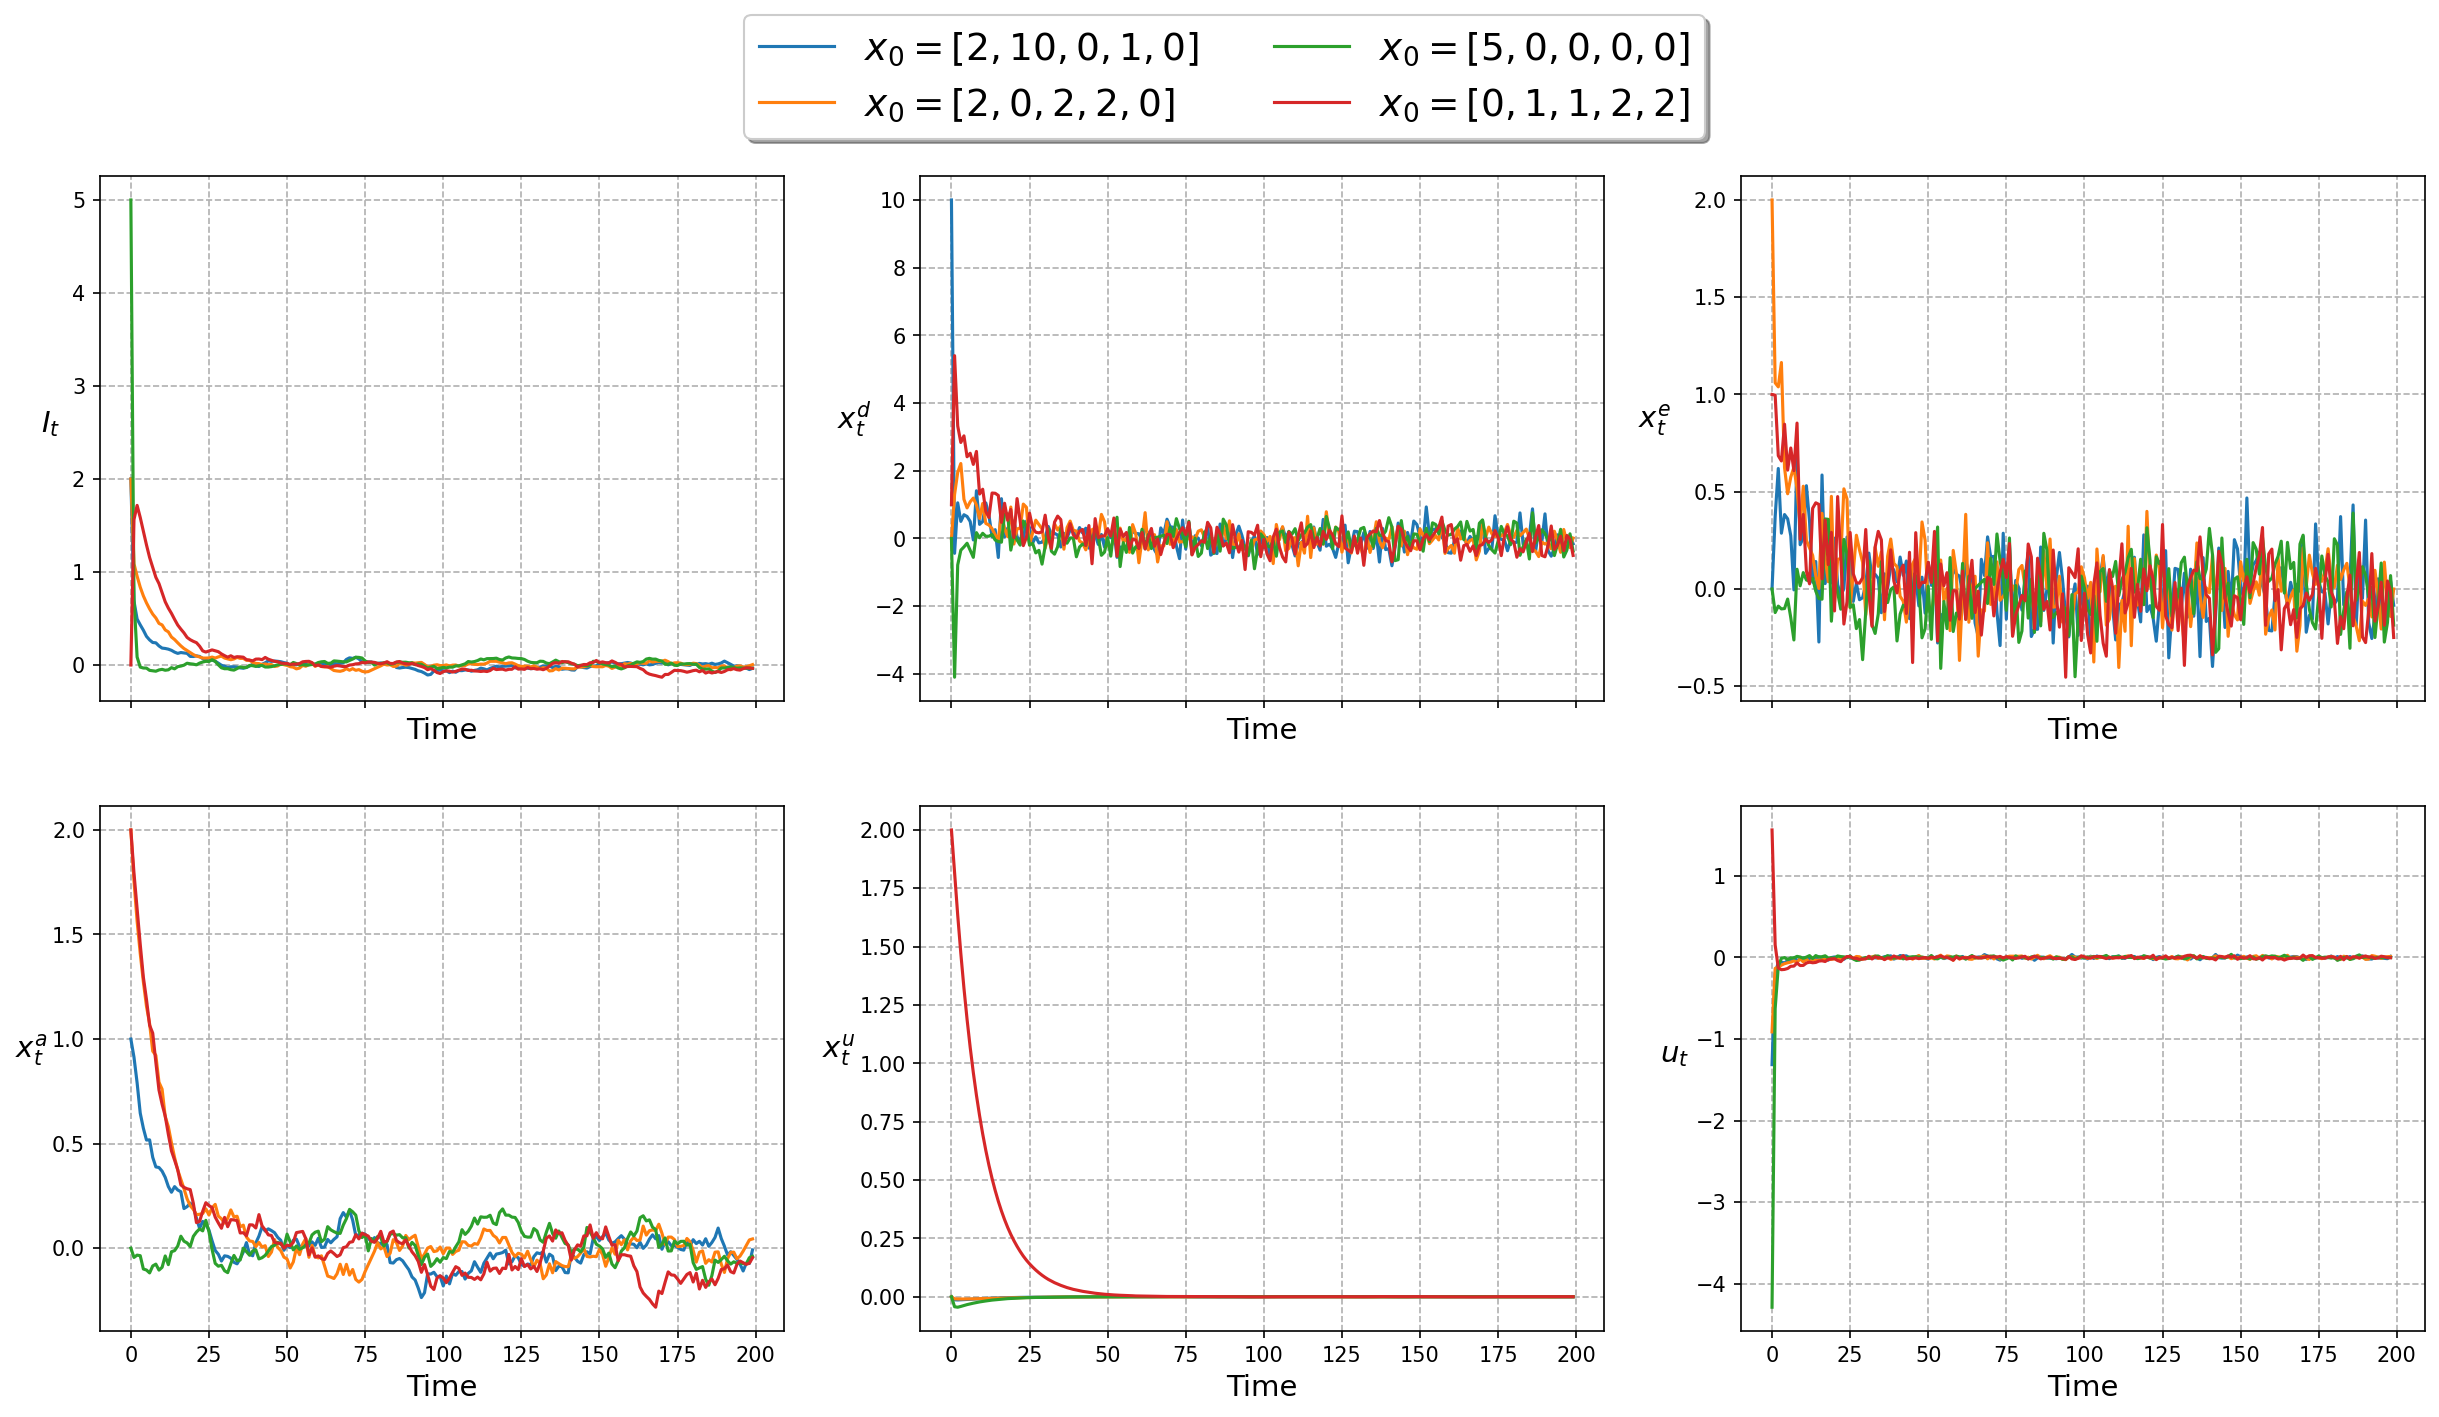

In [123]:
arr_u, arr_x = np.array(list_u), np.array(list_x)

fig, axs = plt.subplots(2, 3, dpi = 150, sharex=True, figsize = (20, 10))
axs = axs.ravel()
ylabels = [r"$I_t$",r"$x^d_t$",r"$x^e_t$", r"$x^a_t$", r"$x^u_t$", r"$u_t$"]

for ax, ylabel in zip(axs, ylabels) :
    ax.set_ylabel(ylabel, rotation = 0, labelpad = 10, fontsize = 14)
    ax.grid(True, which = "both", axis = "both", ls = "--")
    ax.set_xlabel("Time", fontsize = 14) 

for x, u, x0, x0est in zip(arr_x.swapaxes(0, 1), arr_u.swapaxes(0, 1), list_x0, list_x0est):
    for i in range(len(axs)):
        if i == len(axs)-1: 
            axs[i].plot(np.arange(0, u.shape[-1]), np.mean(u.squeeze(), axis = 0))
        else : 
            axs[i].plot(np.arange(0, x.shape[-1]), np.mean(x[:, i, :], axis = 0))

# ax1.legend()

fig.legend([f"$x_0 = [{x0[0]},{x0[1]}, {x0[2]}, {x0[3]},{x0[-1]}]$" for x0 in list_x0], loc = "upper center", ncol = 2, shadow = True, bbox_to_anchor=(0.5, 1.0), fontsize = 18)
fig.savefig("figures/trajectories.pdf")
plt.show()

#### Compute the reward 

In [124]:
N_traj = 50
nsteps = 200
P0 = Sigma_x

list_x0 = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]

list_x0est = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]

list_Eg, list_LQR = [], []

for x0, x0est in zip(list_x0, list_x0est):

    list_x, list_x_est, list_u, list_y = [], [], [], []

    for _ in range(N_traj):
        x, x_est, u, y = simulateWithKalmanFilter(x0, x0est, P0, Sigma_x, A, B.reshape((-1,1)), C, nsteps, K_star)
        list_x.append(x)
        list_x_est.append(x_est)
        list_u.append(u)
        list_y.append(y)

    arr_x, arr_x_est, arr_u, arr_y = np.array(list_x), np.array(list_x_est), np.array(list_u), np.array(list_y)
    x_monte_carlo, E_g, V_g, LQR = monte_carlo_simulation(arr_x, arr_u, 100, A, B, Sigma_x)

    list_Eg.append(E_g)
    list_LQR.append(LQR)

In [125]:
print("Objective Cost : ", *list_LQR)

Objective Cost :  0.0022752002237420824 -0.02405464824703823 0.13261372371432648 -0.09724242357851995


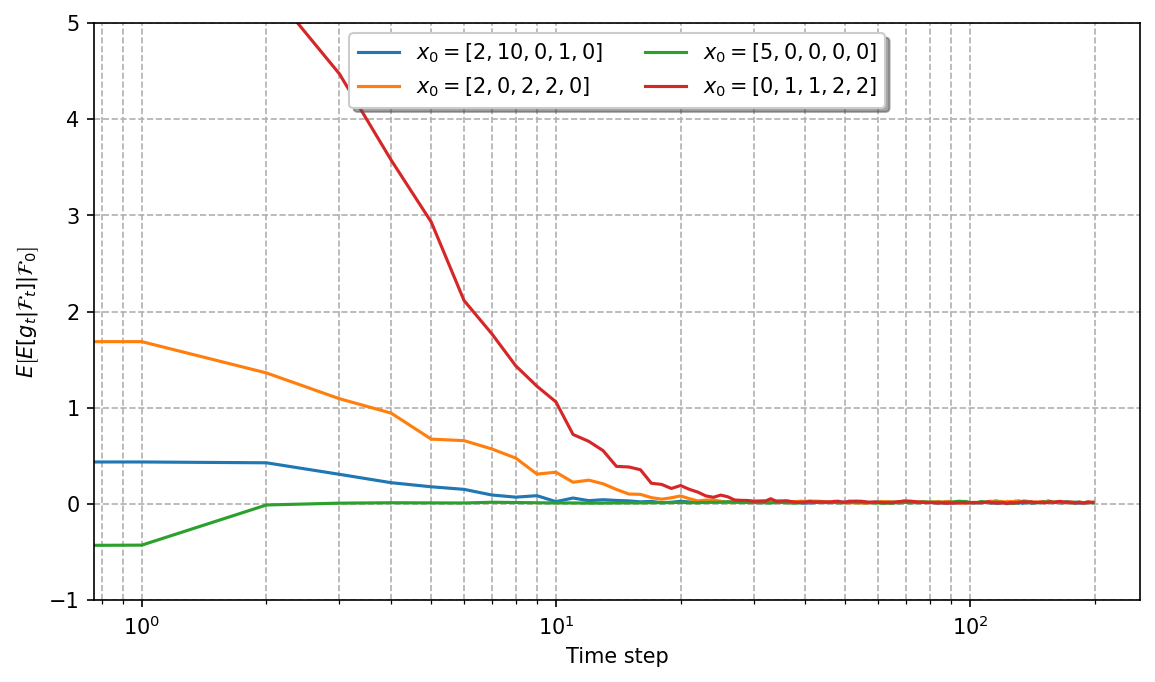

In [126]:
fig = plt.figure(figsize=(9, 5), dpi = 150)
lines = []
for Eg in list_Eg:
    mean_g = np.mean(Eg, axis=0)
    var_g = np.var(Eg, axis=0)
    line, = plt.semilogx(mean_g)
    lines.append(line)

    # plt.fill_between(np.arange(nsteps-1), mean_g - np.sqrt(var_g), mean_g + np.sqrt(var_g), alpha=0.2)

# plt.fill_between([], [], [], color='gray', alpha=0.2)
plt.xlabel("Time step")
plt.ylabel(r"$E\left[E[g_t|\mathcal{F}_t] | \mathcal{F}_0\right]$")
plt.ylim(-1, 5)
plt.legend(lines, [rf"$x_0 = [{x0[0]}, {x0[1]}, {x0[2]}, {x0[3]}, {x0[4]}]$" for x0 in list_x0], ncol=2, loc = "upper center", shadow = True)
plt.grid(True, which="both", axis = "both", ls="--")    
plt.savefig("figures/g_t.pdf")
plt.show()

# Question 4

In [127]:
def simulateNonlinearSystemWithLQG(x0, nsteps, K):
    """
    Simulate a non-linear system with LQG control.

    Parameters
    ----------
    x0 : np.array
        The initial state of the system.
    nsteps : int
        Number of time steps.
    K : np.array
        LQG gain matrix.

    Returns
    -------
    x : np.array
        System states at each time step.
    u : np.array
        Control inputs at each time step.
    """

    x = np.zeros((x0.shape[0], nsteps))     # True state
    u = np.zeros(nsteps-1)                  # Control input

    # Initialize
    x[:, 0] = x0

    for t in range(nsteps - 1):

        I = x[0,t]
        x_a = x[3,t]
        x_u = x[4,t]

        # Control input based on the LQG controller
        u[t] = -K @ x[:, t]
     
        # Update state 
        F = np.array([I + u[t],
        x_a + x_u + GAMMA_U* u[t] + ALPHA_U * u[t] * x_u,
        THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[t] + (THETA - KAPPA) * ALPHA_U * u[t] * x_u,
        (1 - OMEGA_A) * x_a,
        (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[t]
        ]).reshape(-1)

        xi_d = np.random.normal(0, 1)
        xi_a = np.random.normal(0, 1)

        xi = np.array([0, SIGMA_D*xi_d, THETA*SIGMA_D*xi_d, BETA_A*xi_a, 0]).reshape(-1)

        x[:, t+1] = F + xi

    return x, u

Modify the previous `monte_carlo_simulation` implementation to work with the non linear model

In [128]:
def monte_carlo_simulation_nl(x : np.ndarray, u : np.ndarray, M : int, Sigma_x : np.ndarray):
    """
    Compute the Monte Carlo approximations : 
        * E[g_t | x_t, x_{t-1}, ..., x_0]
        * var[g_t | x_t, x_{t-1}, ..., x_0]
        * E[(x_t u_t) L (x_t u_t)^T | x_t, x_{t-1}, ..., x_0] (with L = [[Q S], [S^T R]])

    and finally compute the LQR cost with the above approximations.
    
    For the N given trajectories (x, u), we compute the conditional expectation and variance of the reward g_t by performing M monte-carlo simulation
    at each time step and for each trajectories. The model used is the non-linear one !

                
    Parameters
    ----------
    x : np.ndarray
        State trajectories.
    u : np.ndarray
        Control trajectories.
    M : int
        # of particles for the conditional expectation.
    A : np.ndarray
        System matrix.
    B : np.ndarray
        Control matrix.
    Sigma_x : np.ndarray
        Covariance matrix of the state noise.

    Returns
    -------

    x_monte_carlo : np.ndarray
        State trajectory with the M additional Monte-Carlo simulation.
    
    E_g : np.ndarray
        E[g_t | x_t, x_{t-1}, ..., x_0]    
    V_g : np.ndarray
        var[g_t | x_t, x_{t-1}, ..., x_0]

    LQR : np.ndarray    
        LQR cost 
    """
    N_traj, state_dim, nStep = x.shape
    x_monte_carlo = np.zeros((N_traj, M, nStep, state_dim)) 
    g_monte_carlo = np.zeros((N_traj, M, nStep-1,))

    x_monte_carlo[..., 0, :] = x[:, np.newaxis, :, 0]

    for t in range(nStep-1):
        
        I = x[:, 0, t]
        x_a = x[:, 3, t]
        x_u = x[:, 4, t]
        
        w_k = np.random.multivariate_normal(np.zeros(state_dim), Sigma_x, M) # (M, state_dim)

        F = np.array([
            I + u[:, t],
            x_a + x_u + GAMMA_U* u[:, t] + ALPHA_U * u[:, t] * x_u,
            THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[:, t] + (THETA - KAPPA) * ALPHA_U * u[:, t] * x_u,
            (1 - OMEGA_A) * x_a,
            (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[:, t]
        ]).swapaxes(0, 1) # (N_traj, state_dim)

        
        x_monte_carlo[..., t+1, :] =  F[:, np.newaxis, :] + w_k
        g_monte_carlo[..., t] = x_monte_carlo[..., t, 0]*x_monte_carlo[..., t+1, 1] + u[:,t, np.newaxis]*x_monte_carlo[..., t+1, 2]


    E_g = np.mean(g_monte_carlo, axis=1)
    V_g = np.var(g_monte_carlo, axis=1)

    
    u_expended = np.tile(u[:, np.newaxis, :, np.newaxis], (1, M, 1, 1)) # (N_traj, M, nStep, 1)
    v = np.concatenate((x_monte_carlo[..., :nStep-1, :], u_expended), axis=-1) # (N_traj, M, nStep, 6)
    
    LQR_t = np.mean(np.einsum("nmtk, nmtk -> nmt", v, np.einsum("kl, nmtl -> nmtk", L, v)), axis=1)
    LQR = np.mean(np.mean(LQR_t, axis=0))

    return x_monte_carlo, E_g, V_g, LQR

In [129]:
N_traj = 50
nsteps = 200
P0 = Sigma_x

list_x0 = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]
    
list_Eg, list_LQR = [], []

for x0 in list_x0:

    list_x, list_u = [], []

    for _ in range(N_traj):
        x, u = simulateNonlinearSystemWithLQG(x0, nsteps, K_star)
        list_x.append(x)
        list_u.append(u)
        

    arr_x, arr_u = np.array(list_x), np.array(list_u)
    x_monte_carlo, E_g, V_g, LQR = monte_carlo_simulation_nl(arr_x, arr_u, 100, Sigma_x)

    list_Eg.append(E_g)
    list_LQR.append(LQR)

In [130]:
print("Objective Cost :", *list_LQR)

Objective Cost : 0.0011898538787267628 -0.02112257127247881 0.13117785805594145 -0.0979204474505811


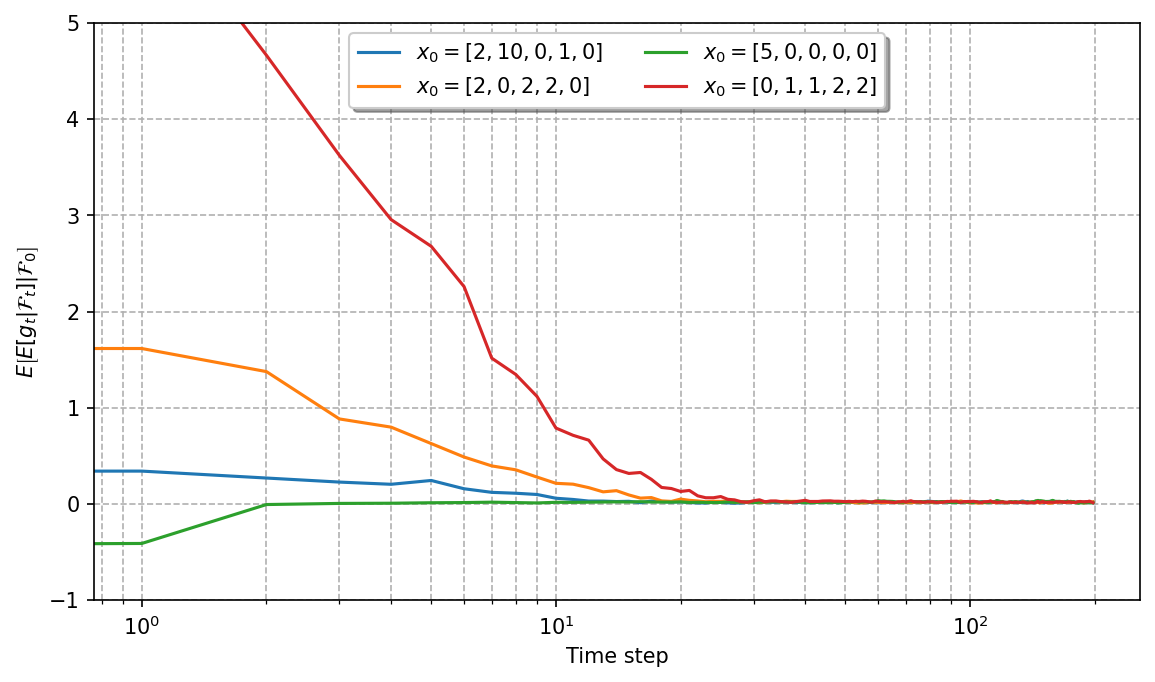

In [131]:
fig = plt.figure(figsize=(9, 5), dpi = 150)
lines = []
for Eg in list_Eg:
    mean_g = np.mean(Eg, axis=0)
    var_g = np.var(Eg, axis=0)
    line, = plt.semilogx(mean_g)
    lines.append(line)

    # plt.fill_between(np.arange(nsteps-1), mean_g - np.sqrt(var_g), mean_g + np.sqrt(var_g), alpha=0.2)

# plt.fill_between([], [], [], color='gray', alpha=0.2)
plt.xlabel("Time step")
plt.ylabel(r"$E\left[E[g_t|\mathcal{F}_t] | \mathcal{F}_0\right]$")
plt.ylim(-1, 5)
plt.legend(lines, [rf"$x_0 = [{x0[0]}, {x0[1]}, {x0[2]}, {x0[3]}, {x0[4]}]$" for x0 in list_x0] , ncols= 2, loc = "upper center", shadow = True)
plt.grid(True, which="both", axis = "both", ls="--")    
plt.savefig("figures/g_t_nl.pdf")
plt.show()

In [133]:
nsteps = 200
N_traj = 10

list_x0 = [
    np.array([2, 10, 0, 1, 0]),
    np.array([2, 0, 2, 2, 0]),
    np.array([5, 0, 0, 0, 0]),
    np.array([0, 1, 1, 2, 2]),
]
list_u, list_x = [[] for _ in range(N_traj)], [[] for _ in range(N_traj)]

for x0 in  list_x0:
    for i in range(N_traj):
        x, u = simulateNonlinearSystemWithLQG(x0, nsteps, K_star)
        list_u[i].append(u)
        list_x[i].append(x)

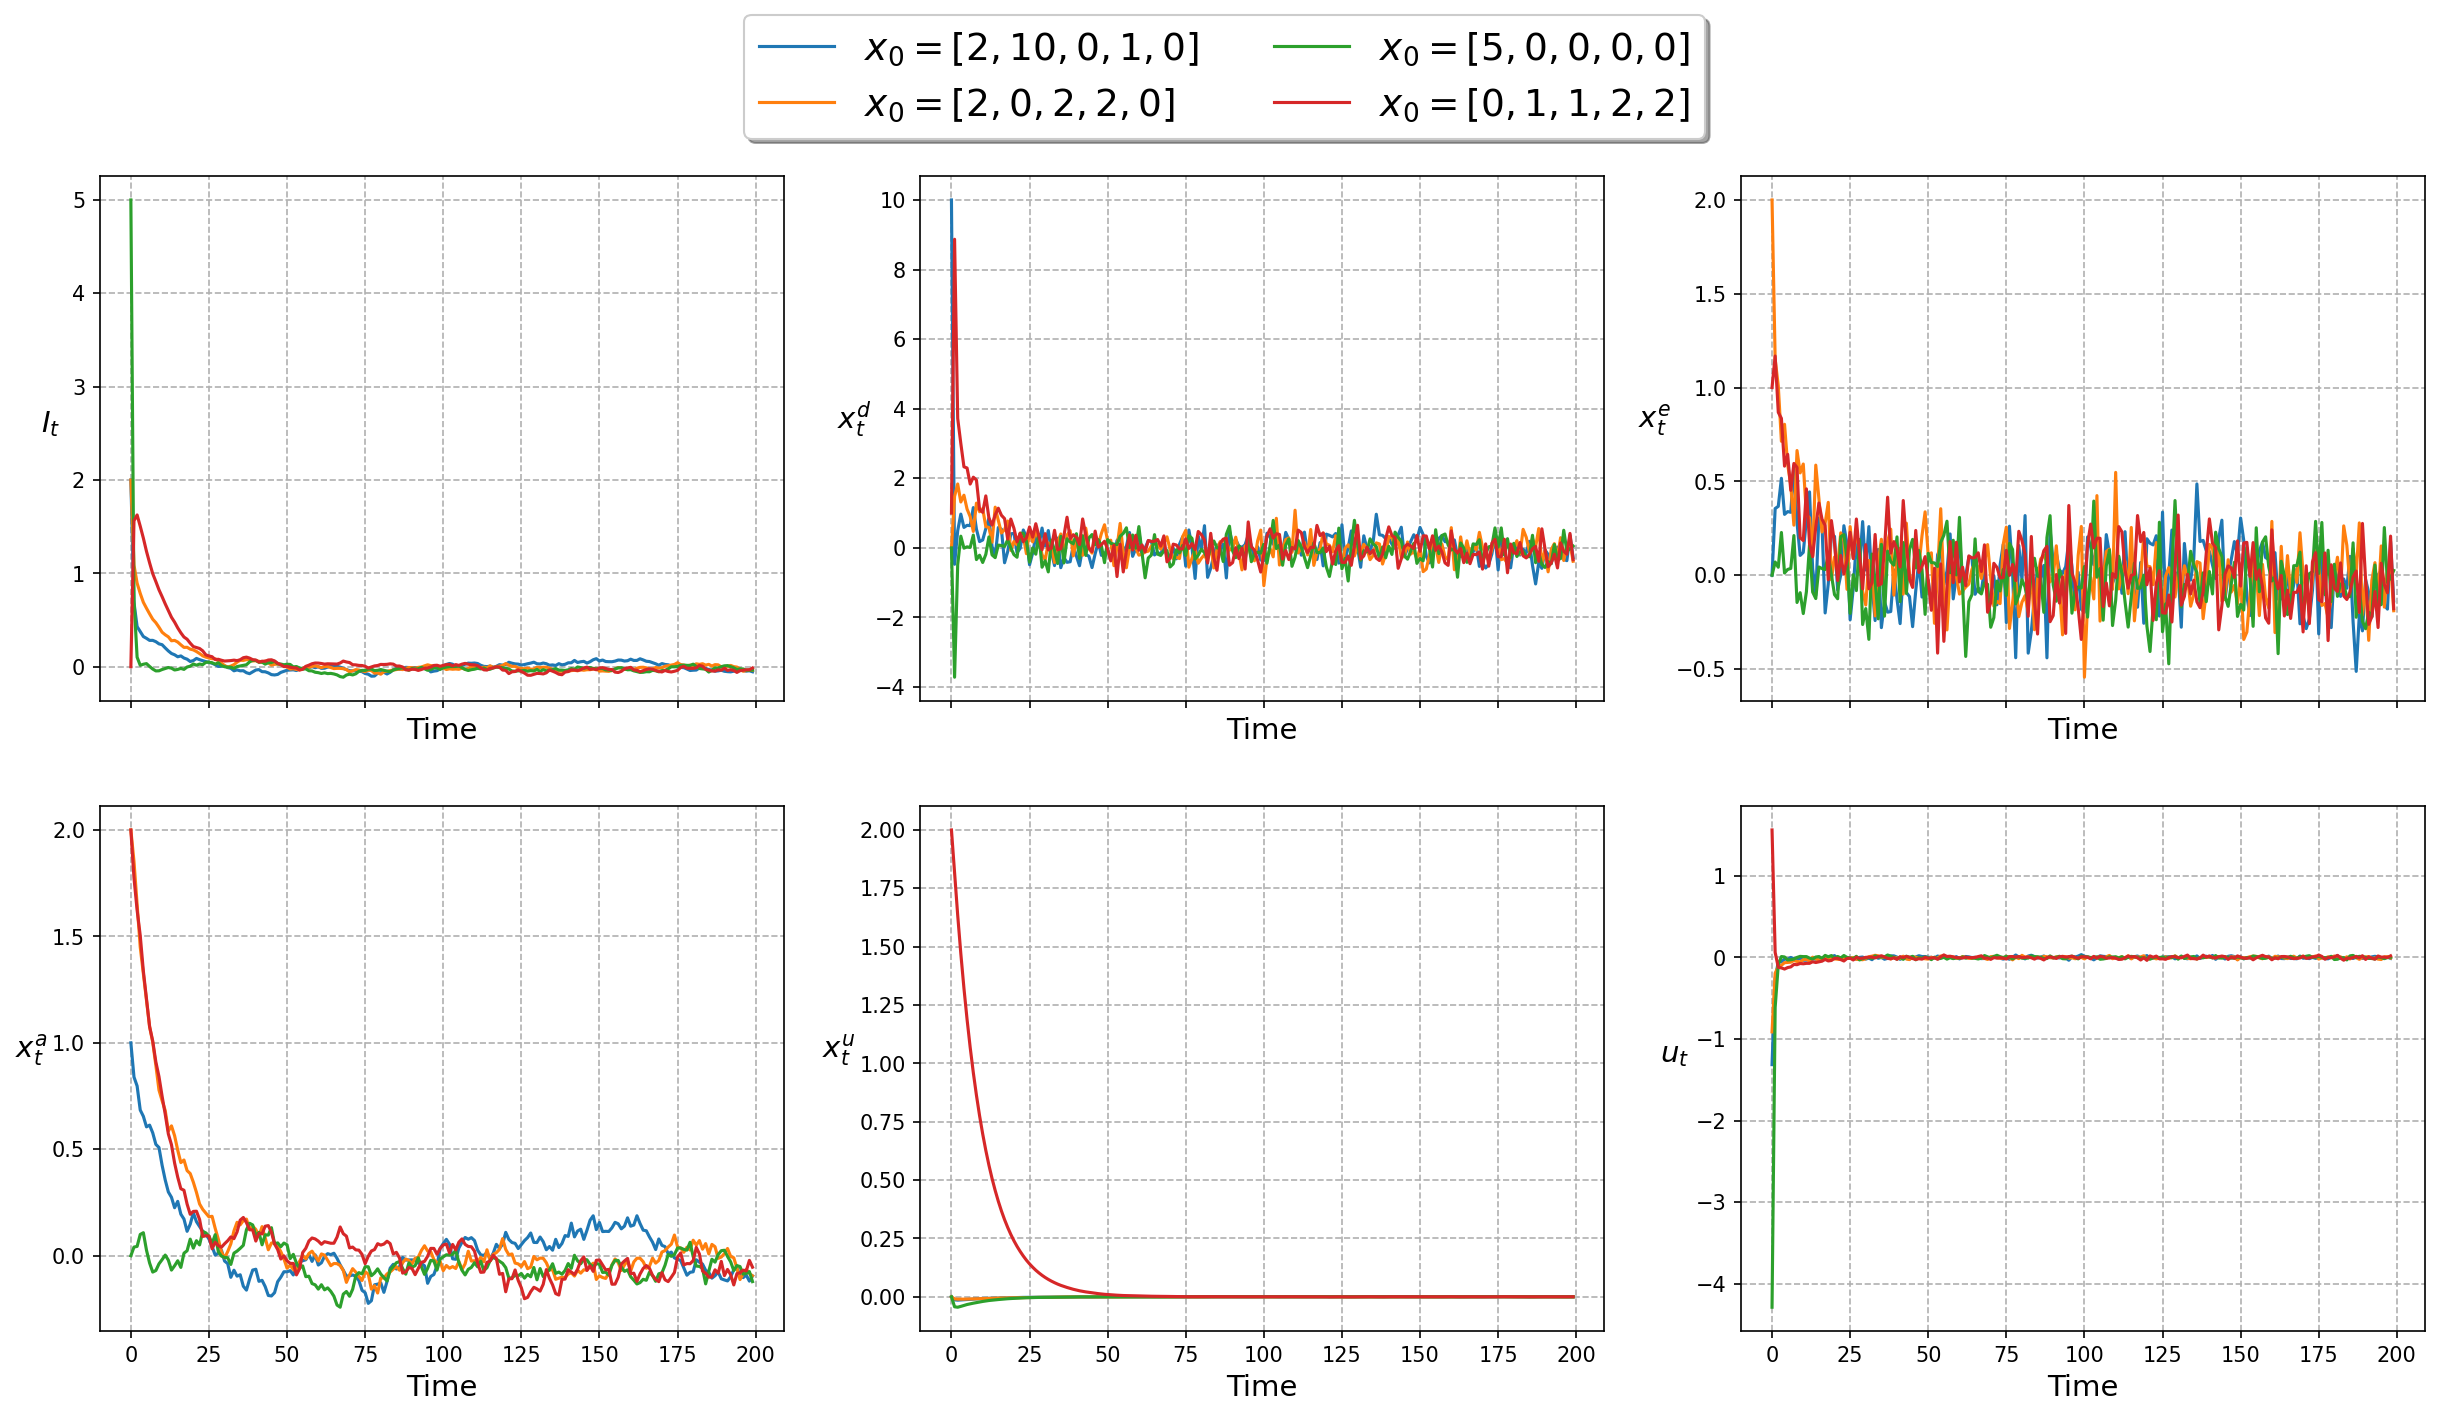

In [134]:
arr_u, arr_x = np.array(list_u), np.array(list_x)

fig3, axs = plt.subplots(2, 3, dpi = 150, sharex=True, figsize = (20, 10))
axs = axs.ravel()
ylabels = [r"$I_t$",r"$x^d_t$",r"$x^e_t$", r"$x^a_t$", r"$x^u_t$", r"$u_t$"]

for ax, ylabel in zip(axs, ylabels) :
    ax.set_ylabel(ylabel, rotation = 0, labelpad = 10, fontsize = 14)
    ax.grid(True, which = "both", axis = "both", ls = "--")
    ax.set_xlabel("Time", fontsize = 14) 

for i, (x, u)in enumerate(zip(arr_x.swapaxes(0, 1), arr_u.swapaxes(0, 1))):
    for i in range(len(axs)):
        if i == len(axs) - 1:
            axs[i].plot(np.arange(0, u.shape[-1]), np.mean(u, axis = 0))    
        else :
            axs[i].plot(np.arange(0, x.shape[-1]), np.mean(x[:,i, :], axis = 0))


fig3.legend([f"$x_0 = [{x0[0]},{x0[1]}, {x0[2]}, {x0[3]},{x0[-1]}]$" for x0 in list_x0], loc = "upper center", ncol = 2, bbox_to_anchor=(0.5, 1.0),fontsize = 18, shadow = True)
fig3.savefig("figures/trajectories_nl.pdf")
plt.show()

# Question 5

In [97]:
import itertools
import tqdm
import mdptoolbox

We discretize the state space

In [98]:
N_STATE = 25

In [99]:
I = np.arange(0, N_STATE, 1)
X_A = np.linspace(-1, 1, N_STATE)
X_U = np.linspace(-1, 1, N_STATE)
U = np.array([-1, 0, 1])


state_space = []

for I_i, xa_i, xu_i in itertools.product(I, X_A, X_U):
    state_space.append((I_i, xa_i, xu_i))

state_to_index = {state: idx for idx, state in enumerate(state_space)}
u_to_index = {u_i: idx for idx, u_i in enumerate(U)}

Define constant & helper functions

In [100]:
P_TRESH = 1e-2
N_SIM = 50

In [101]:
def get_state_index(state):
    return state_to_index.get(state, None)

def get_u_index(u_value):
    return u_to_index.get(u_value, None)

def discretize(value, grid):
    """Discretize a continuous value to the nearest point in the grid."""
    return grid[np.argmin(np.abs(grid - value))]

def make_step(state, u):
    """Helper function to make a step in the environment."""
    I_t, x_a, x_u = state

    # Generate noise
    noise_a = np.random.randn()
    noise_d = np.random.randn()
  
    # Compute next states
    I_next = I_t + u
    x_a_next = (1-OMEGA_A)*x_a + noise_a*BETA_A
    x_u_next = (1-OMEGA_U)*x_u + OMEGA_U*BETA_U*u 

    # Clip continuous values to [-1, 1]
    x_a_next = np.clip(x_a_next, -1, 1)
    x_u_next = np.clip(x_u_next, -1, 1)
    I_next = np.clip(I_next, 0, N_STATE-1)

    # Discretize the next states
    I_next_disc = int(round(I_next))
    x_a_next_disc = discretize(x_a_next, X_A)
    x_u_next_disc = discretize(x_u_next, X_U)

    # Compute x_d_next and x_e_next if needed for cost calculation
    r_u_next = x_u + GAMMA_U * u + ALPHA_U * u * x_u 
    x_d_next = x_a + r_u_next + SIGMA_D * noise_d
    x_e_next = THETA*x_d_next - KAPPA*r_u_next

    return (I_next_disc, x_a_next_disc, x_u_next_disc), np.array([I_next, x_d_next, x_e_next, x_a_next, x_u_next])



Compute the probability transitions & transitions costs

In [102]:
p_prob = np.zeros((len(state_space), len(state_space), len(U)))
costs = np.zeros((len(state_space), len(state_space), len(U)))

for i, state in tqdm.tqdm(enumerate(state_space), total=len(state_space)):

    for ii, u_i in enumerate(U): 
        for _ in range(N_SIM):

            state_next, state_next_extended = make_step(state, u_i)
            # Compute the probability
      
            next_state_index = get_state_index(state_next)
            p_prob[i, next_state_index, ii] += 1

            # Compute the cost
            costs[i, next_state_index, ii] += np.concatenate([state_next_extended, [u_i]]) @ L @ np.concatenate([state_next_extended, [u_i]])
  
    
        p_prob[i, :, ii] /= N_SIM
        costs[i, :, ii] /= N_SIM
        
mask = p_prob < P_TRESH
p_prob[mask] = 0.0

# re-normalize the probabilities after thresholding
total_probs = np.sum(p_prob, axis=1, keepdims=True)
p_prob = np.where(total_probs > 0, p_prob / total_probs, p_prob)

100%|██████████| 15625/15625 [08:09<00:00, 31.93it/s]


We now use the mdptoolbox 

In [103]:
gamma = 0.99

P = np.moveaxis(p_prob, -1, 0)
expected_costs = np.einsum("ijk, ijk -> ik", p_prob, costs) 


value_iteration = mdptoolbox.mdp.ValueIteration(transitions=P, reward=-expected_costs, discount=gamma)
value_iteration.run()

In [104]:
policy_idx = value_iteration.policy

In [105]:
def policy(state):
    """Return the optimal action for a given state."""
    state_idx = get_state_index(state)
    return U[policy_idx[state_idx]]

In [106]:
def simulate_system_MDP(x0 : np.ndarray, nsteps : int, policy : callable) -> np.ndarray:

    x = np.zeros((x0.shape[0], nsteps))     # True state
    u = np.zeros(nsteps-1)                  # Control input

    # Initialize
    x[:, 0] = x0

    x[0, 0] = discretize(x[0, 0], I)
    x[3, 0] = discretize(x[3, 0], X_A)
    x[4, 0] = discretize(x[4, 0], X_U)

    for t in range(nsteps - 1):

        I_t, x_a, x_u = x[0,t], x[3,t], x[4,t]
        u[t] = policy((I_t, x_a, x_u))
    
        # Update state 
        F = np.array([
            I_t + u[t],
            x_a + x_u + GAMMA_U* u[t] + ALPHA_U * u[t] * x_u,
            THETA * x_a + (THETA - KAPPA) * x_u + (THETA - KAPPA) * GAMMA_U * u[t] + (THETA - KAPPA) * ALPHA_U * u[t] * x_u,
            (1 - OMEGA_A) * x_a,
            (1 - OMEGA_U) * x_u + OMEGA_U * BETA_U * u[t]
        ]).reshape(-1)

        xi_d = np.random.normal(0, 1)
        xi_a = np.random.normal(0, 1)

        xi = np.array([0, SIGMA_D*xi_d, THETA*SIGMA_D*xi_d, BETA_A*xi_a, 0]).reshape(-1)

        x[:, t+1] = F + xi

        x[0, t+1] = discretize(x[0, t+1], I)
        x[3, t+1] = discretize(x[3, t+1], X_A)
        x[4, t+1] = discretize(x[4, t+1], X_U)


    return x, u

In [107]:
nsteps = 200
N_traj = 10

list_x0 = [
    np.array([2, 1, 0, 1, 0]),
    np.array([2, 0, 1, 1, 0]),
    np.array([2, 0, 0, 0, 0]),
    np.array([0, 1, 1, 1, 1]),
]
list_u, list_x = [[] for _ in range(N_traj)], [[] for _ in range(N_traj)]

for x0 in  list_x0:
    for i in range(N_traj):
        x, u = simulate_system_MDP(x0, nsteps, policy)
        list_u[i].append(u)
        list_x[i].append(x)

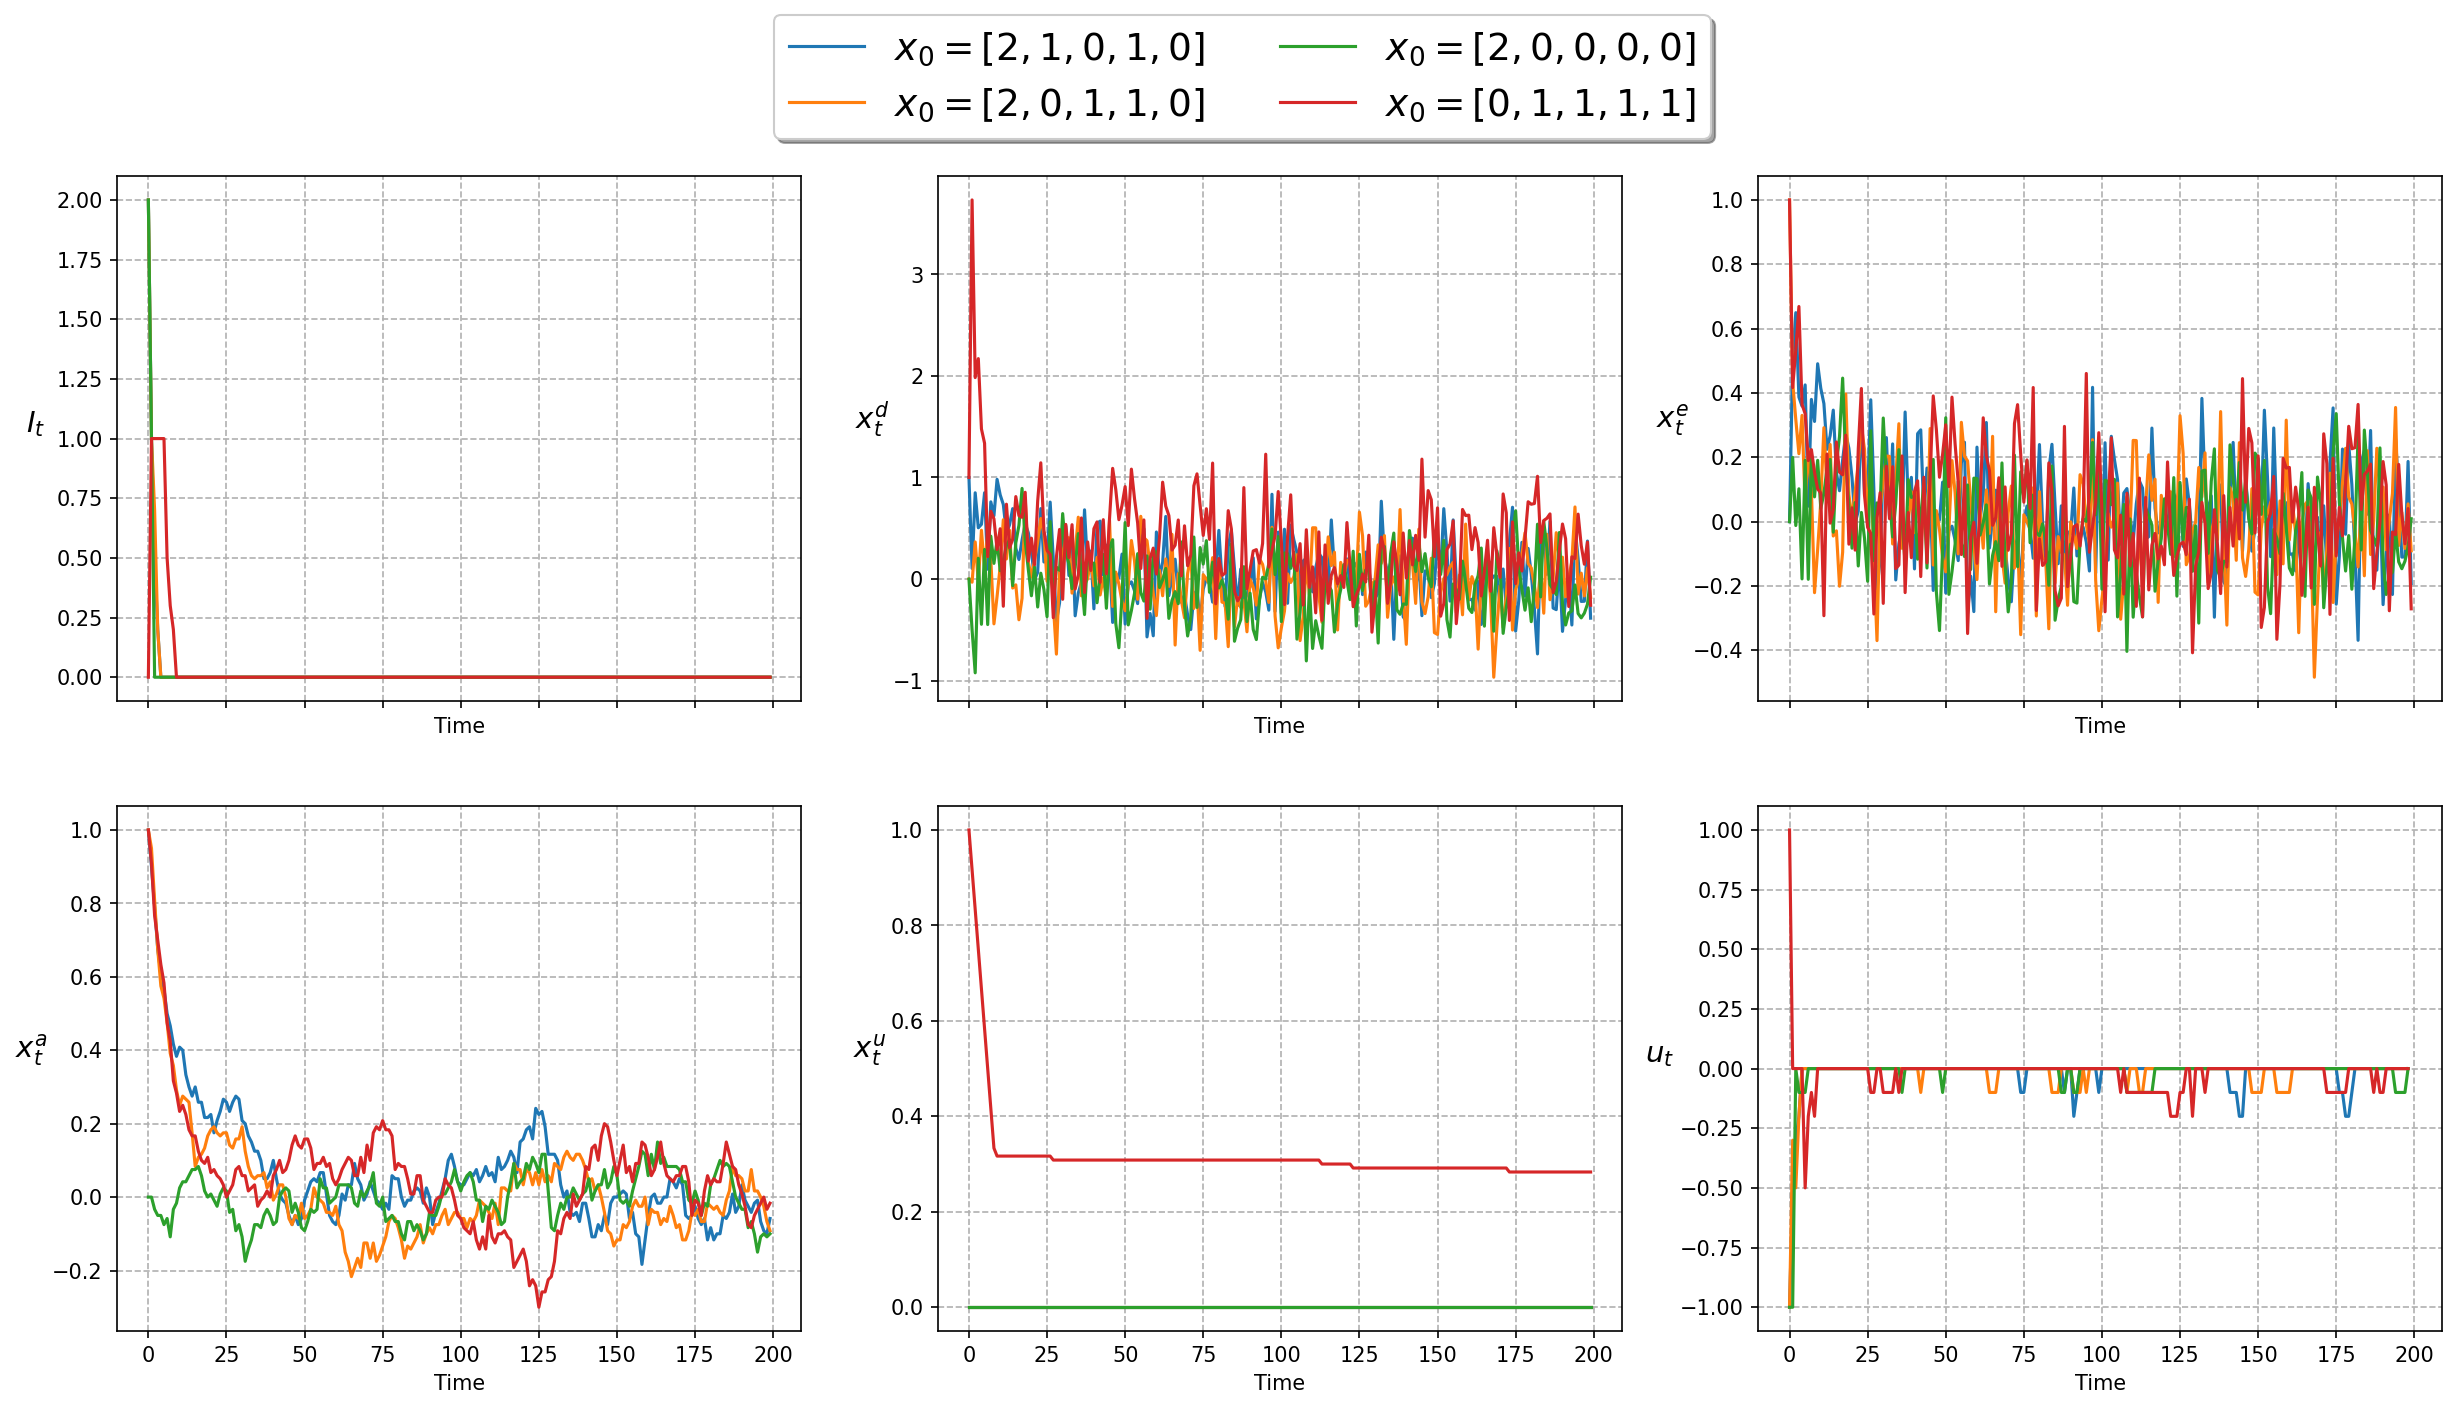

In [108]:
arr_u, arr_x = np.array(list_u), np.array(list_x)

fig3, axs = plt.subplots(2, 3, dpi = 150, sharex=True, figsize = (20, 10))
axs = axs.ravel()
ylabels = [r"$I_t$",r"$x^d_t$",r"$x^e_t$", r"$x^a_t$", r"$x^u_t$", r"$u_t$"]

for ax, ylabel in zip(axs, ylabels) :
    ax.set_ylabel(ylabel, rotation = 0, labelpad = 10, fontsize = 14)
    ax.grid(True, which = "both", axis = "both", ls = "--")
    ax.set_xlabel("Time") 

for i, (x, u)in enumerate(zip(arr_x.swapaxes(0, 1), arr_u.swapaxes(0, 1))):
    for i in range(len(axs)):
        if i == len(axs) - 1:
            axs[i].plot(np.arange(0, u.shape[-1]), np.mean(u, axis = 0))    
        else :
            axs[i].plot(np.arange(0, x.shape[-1]), np.mean(x[:, i, :], axis = 0))


fig3.legend([f"$x_0 = [{x0[0]},{x0[1]}, {x0[2]}, {x0[3]},{x0[-1]}]$" for x0 in list_x0], loc = "upper center", ncol = 2, bbox_to_anchor=(0.5, 1.0),fontsize = 18, shadow = True)
fig3.savefig("figures/trajectories_mdp.pdf")
plt.show()

In [109]:
N_traj = 50
nsteps = 200
P0 = Sigma_x

list_x0 = [
    np.array([2, 1, 0, 1, 0]),
    np.array([2, 0, 1, 1, 0]),
    np.array([2, 0, 0, 0, 0]),
    np.array([0, 1, 1, 1, 1]),
]
    
list_Eg, list_LQR = [], []

for x0 in list_x0:

    list_x, list_u = [], []

    for _ in range(N_traj):
        x, u = simulate_system_MDP(x0, nsteps, policy)
        list_x.append(x)
        list_u.append(u)
    
    arr_x, arr_u = np.array(list_x), np.array(list_u)
    x_monte_carlo, E_g, V_g, LQR = monte_carlo_simulation_nl(arr_x, arr_u, 100, Sigma_x)

    list_Eg.append(E_g)
    list_LQR.append(LQR)

In [110]:
print("Objective Cost :", *list_LQR)

Objective Cost : 0.019936047047245203 0.02136790324398791 0.03197472813584227 -0.004468760570513041


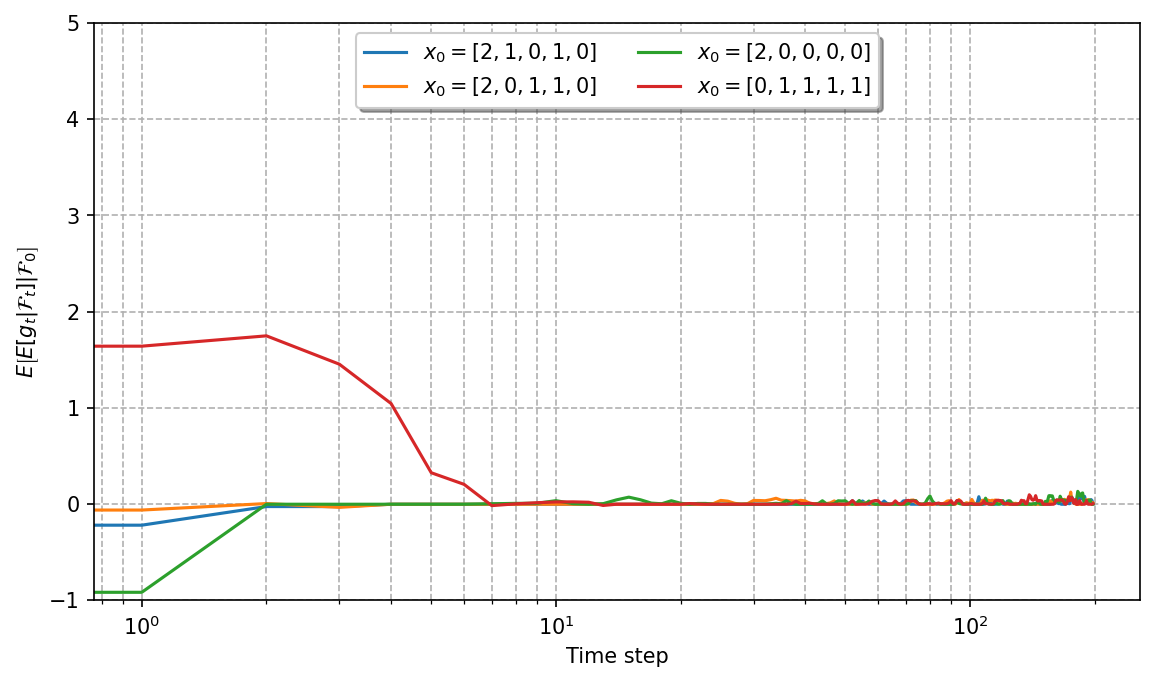

In [111]:
fig = plt.figure(figsize=(9, 5), dpi = 150)
lines = []
for Eg in list_Eg:
    mean_g = np.mean(Eg, axis=0)
    var_g = np.var(Eg, axis=0)
    line, = plt.semilogx(mean_g)
    lines.append(line)

    # plt.fill_between(np.arange(nsteps-1), mean_g - np.sqrt(var_g), mean_g + np.sqrt(var_g), alpha=0.2)

# plt.fill_between([], [], [], color='gray', alpha=0.2)
plt.xlabel("Time step")
plt.ylabel(r"$E\left[E[g_t|\mathcal{F}_t] | \mathcal{F}_0\right]$")
plt.ylim(-1, 5)
plt.legend(lines, [rf"$x_0 = [{x0[0]}, {x0[1]}, {x0[2]}, {x0[3]}, {x0[4]}]$" for x0 in list_x0] , ncols= 2, loc = "upper center", shadow = True)
plt.grid(True, which="both", axis = "both", ls="--")    
plt.savefig("figures/g_t_mdp.pdf") 
plt.show()